In [1]:
pip install torch torchvision numpy pillow opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
pip install tifffile rasterio


  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
   ---------------------------------------- 0.0/30.1 MB ? eta -:--:--
   -- ------------------------------------- 2.1/30.1 MB 11.5 MB/s eta 0:00:03
   ----- ---------------------------------- 4.5/30.1 MB 10.7 MB/s eta 0:00:03
   --------- ------------------------------ 7.3/30.1 MB 11.7 MB/s eta 0:00:02
   ------------- -------------------------- 10.5/30.1 MB 12.6 MB/s eta 0:00:02
   ------------------ --------------------- 13.6/30.1 MB 13.0 MB/s eta 0:00:02
   -------------------- ------------------- 15.7/30.1 MB 12.4 MB/s eta 0:00:02
   ---------------------- ----------------- 17.3/30.1 MB 11.8 MB/s eta 0:00:02
   ------------------------ --------------- 18.6/30.1 MB 11.3 MB/s eta 0:00:02
   -------------------------- ------------- 19.9/30.1 MB 10.6 MB/s eta 0:00:01
   --------------------------- ------------ 21.0/30.1 MB 9.9 MB/s eta 0:00:01
   ---------------------------- ----------- 21.8/30.1 MB 9.3 MB/s eta 0:00:01
   -


[notice] A new release of pip is available: 24.3.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image


# Generator Architecture

class ResidualBlock(nn.Module):

    def __init__(self, c):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(c,c,3,1,1),
            nn.BatchNorm2d(c),
            nn.PReLU(),
            nn.Conv2d(c,c,3,1,1),
            nn.BatchNorm2d(c)
        )

    def forward(self,x):
        return x + self.block(x)


class Generator(nn.Module):

    def __init__(self):
        super().__init__()

        self.start = nn.Sequential(
            nn.Conv2d(3,64,9,1,4),
            nn.PReLU()
        )

        self.res = nn.Sequential(
            *[ResidualBlock(64) for _ in range(8)]
        )

        self.mid = nn.Sequential(
            nn.Conv2d(64,64,3,1,1),
            nn.BatchNorm2d(64)
        )

        self.end = nn.Conv2d(64,3,9,1,4)

    def forward(self,x):

        s = self.start(x)
        r = self.res(s)
        m = self.mid(r)

        x = s + m

        return torch.sigmoid(self.end(x))





In [4]:
# Load Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator().to(device)

MODEL_PATH = "G_final.pth"

G.load_state_dict(torch.load(MODEL_PATH, map_location=device))

G.eval()

print("Model loaded!")




Model loaded!


In [12]:
import tifffile
import rasterio
from PIL import Image

def load_lr_image(image_path, device):
    ext = image_path.lower().split(".")[-1]

    if ext in ["png", "jpg", "jpeg"]:
        img = Image.open(image_path).convert("RGB")
        img = np.array(img)

    elif ext in ["tif", "tiff"]:
        try:
            with rasterio.open(image_path) as src:
                img = src.read([1,2,3])  # RGB bands
                img = np.transpose(img, (1,2,0))
        except:
            img = tifffile.imread(image_path)
            if img.ndim == 2:
                img = np.stack([img]*3, axis=-1)
            if img.shape[2] > 3:
                img = img[:, :, :3]

    else:
        raise ValueError("Unsupported format")

    img = img.astype(np.float32)
    img = img / img.max()

    img = torch.from_numpy(img).permute(2,0,1).unsqueeze(0).to(device)
    return img


In [27]:
def save_sr_image(sr_tensor, save_path):
    sr = sr_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Contrast stretching (fixes dark SR)
    sr = (sr - sr.min()) / (sr.max() - sr.min() + 1e-8)

    sr = (sr * 255).astype(np.uint8)

    ext = save_path.lower().split(".")[-1]

    if ext in ["png", "jpg", "jpeg"]:
        Image.fromarray(sr).save(save_path)
    elif ext in ["tif", "tiff"]:
        tifffile.imwrite(save_path, sr)
    else:
        raise ValueError("Unsupported save format")


In [29]:
input_image_path = "inputs/Delhi_Sentinel2_Lr.tif"
output_image_path = "outputs/test.png"

os.makedirs("outputs", exist_ok=True)

G.eval()
with torch.no_grad():
    lr = load_lr_image(input_image_path, device)
    sr = G(lr)

save_sr_image(sr, output_image_path)

print("Super-resolution completed")
print("Saved to:", output_image_path)

Super-resolution completed
Saved to: outputs/test.png


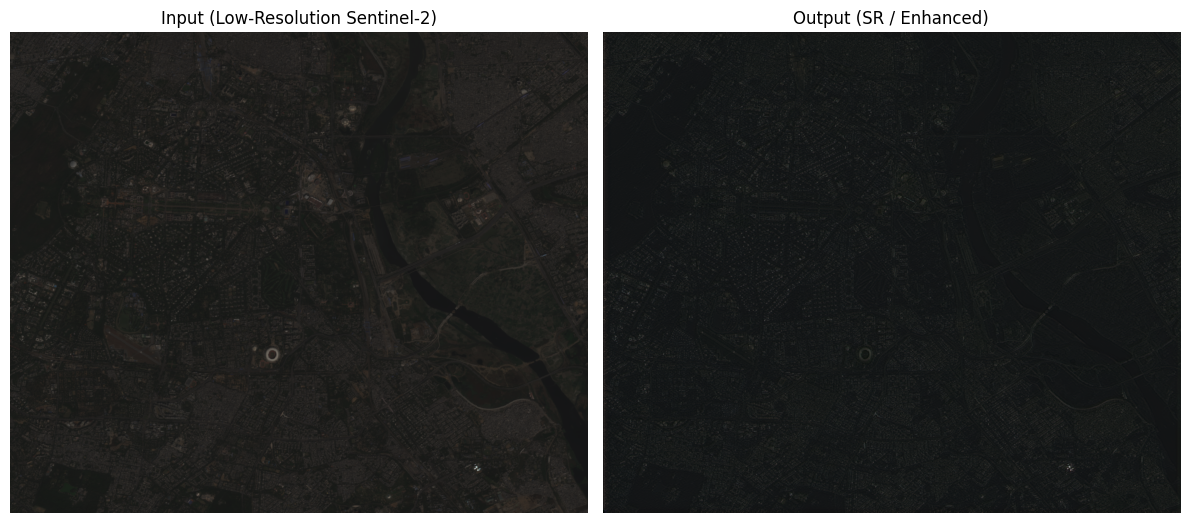

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from PIL import Image

def load_for_display(path):
    ext = path.lower().split(".")[-1]

    if ext in ["png", "jpg", "jpeg"]:
        img = Image.open(path).convert("RGB")
        return np.array(img)

    elif ext in ["tif", "tiff"]:
        with rasterio.open(path) as src:
            img = src.read([1, 2, 3])
            img = np.transpose(img, (1, 2, 0))
            img = img.astype(np.float32)
            img = img / img.max()
            return img

    else:
        raise ValueError("Unsupported format")


# Load images
lr_img = load_for_display(input_image_path)
sr_img = load_for_display(output_image_path)

# Plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(lr_img)
plt.title("Input (Low-Resolution Sentinel-2)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(sr_img)
plt.title("Output (SR / Enhanced)")
plt.axis("off")

plt.tight_layout()
plt.show()
